<a href="https://colab.research.google.com/github/ShinAsakawa/bit/blob/main/notebooks/2022_0604bit_faster_rcnn_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
- date: 2022_0604 original file written at 2022_0319
- filename: 2022_0604bit_faster-rcnn_fine_tuning.ipynb
- ref source: https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook
---

**注**: workers=0 で動作するので時間がかかる

# faster-rcnn 転移学習または微調整を用いた BIT 線分 2 等分課題

[BIT] 図版を [Faster RCNN](https://arxiv.org/abs/1506.01497) で微調整して訓練

* Faster RCNNについては [Faster-RCNNの仕組みをより深く理解するために](https://medium.com/@whatdhack/a-deeper-look-how-faster-rcnn-works-84081284e1cd) の Media 参照。
* [Pytorch 公式チュートリアル文書](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) も参照

転移学習 transfer learning と微調整 fine tuning については，種々考え方がある。
だがここでは，[PyTorch のチュートリアル](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) に従って，
最終層だけ入れ替えて，最終直下層以下の結合係数を固定して考える場合を転移学習と呼ぶことにする。
全層を再学習することを，微調整と呼ぶことにする。
このチュートリアルが参照にしているのは，Karpathy の スタンフォードでの授業 [cs231n の転移学習のノート](https://cs231n.github.io/transfer-learning/) である。


<center>
<img src="https://github.com/ShinAsakawa/bit/blob/main/notebooks/figures/R_CNN.png?raw=1" width="66%"><br/>
<img src="https://miro.medium.com/max/1400/1*1Mj0C4wzi57Z6Z933gb6vA.png" width="66%"><br/>
<div style="backgournd-color:cornsilk;width:66%;text-align:left">

図 Faster-RCNN のブロック図 <!-- Fig 1: Faster-RCNN block diagram.  -->
赤紫色のブロックは訓練時のみ活性化<!--The magenta colored blocks are active only during training. -->
数値はテンソルサイズ<!--The numbers indicate size of the tensors.-->
画像出典: Goswami [A deeper look at how Faster-RCNN works](https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd)
<!-- source: Subrata Goswami [A deeper look at how Faster-RCNN works](https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd)-->
</div>  </center>


<!-- <div class="fig">
<img src="figures/2020Beery_fig3.svg" width="88%"><br/>
Beery et al. (2020) Fig. 3, `Context R-CNN: Long Term Temporal Context for Per-Camera Object Detection`, arXiv:1912.03538
</div> -->


# 1. インストールとインポート
<!-- ## Installs and Imports -->

## 1.1 下準備

必要なライブラリのインストールなど

In [ ]:
import os
import sys
import typing
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    from PIL import ImageFont
    from glob import glob

    !pip install pycocotools --quiet
    !git clone https://github.com/pytorch/vision.git
    !git checkout v0.3.0

    # Download TorchVision repo to use some files from references/detection
    # os.symlink(src,dst) にした方が良いかも
    !cp vision/references/detection/utils.py ./
    !cp vision/references/detection/transforms.py ./
    !cp vision/references/detection/coco_eval.py ./
    !cp vision/references/detection/engine.py ./
    !cp vision/references/detection/coco_utils.py ./
    
    !pip install japanize_matplotlib
    #!pip install albumentataions  # 2022_0604 一時的に中断 colab でエラー発生のため
    
    # 自作ライブラリ
    !git clone https://github.com/ShinAsakawa/bit.git

    # Noto fonts のダウンロードとインストール
    !mkdir Noto_JP_fonts
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifJP.zip
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansJP.zip
    !unzip NotoSerifJP.zip -d Noto_JP_fonts
    !unzip -o NotoSansJP.zip -d Noto_JP_fonts  # `-o` means overwrite 
    !mv Noto_JP_fonts bit
    !mkdir data
    
    noto_font_dir = './bit/Noto_JP_fonts'
    notofonts_fnames = glob(os.path.join(noto_font_dir,'*otf'))
    notofonts = {fname.split('/')[-1].split('.')[0]:{'fname':fname} for fname in notofonts_fnames}
    for fontname in notofonts.keys():
        notofonts[fontname]['data'] = ImageFont.truetype(notofonts[fontname]['fname'])
else:
    # 自分のリポジトリからシンボリックリンクで代用
    for file in ['engine.py', 'utils.py', 'coco_utils.py', 'transforms.py', 'coco_eval.py']:
        if not os.path.exists(file):
            _file = os.path.join('../2020pytorch_vision.git/reference/detection/', file)
            !ln -s ../2020pytorch_vision.git/references/detection/engine.py .
            !ln -s ../2020pytorch_vision.git/references/detection/utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/transforms.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_eval.py .

## 1.2 ライブラリのインポート

In [ ]:
# ライブラリのインポート
# python と機械学習のための基本ライブラリ
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib

# torchvision ライブラリ
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
# torchvision.models.detection.retinanet_resnet50_fpn` で RetinaNet を使用してみることもできる。
# SSDlite なら `torchvision.models.detection.ssdlite320_mobilenet_v3_large`
# SSD は `torchvision.models.detection.ssd300_vgg16` を用いる
# これらモデルの詳細については `https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#instance-seg-output`

# ヘルパライブラリをインポート
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# #画像のデータ拡張 当面は不要
# だが `get_transform()` で 用いているため試しに使ってみる
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

# 2. データセットの作成

## 2.1 自作ライブラリの読み込み，下請け関数の定義

In [ ]:
%load_ext autoreload
%autoreload 2
from bit import BIT

if isColab:
    bit = BIT(fontdata=notofonts)
else:
    bit = BIT()
images, bboxes = bit.make_line_bisection_task_images(N=2, n_lines=4)

print(f'bboxes:{bboxes}, len(bboxes):{len(bboxes)}')

# DETR のサンプルプログラムを借用, bounding boxes の描画時に使用
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS = COLORS * 100

import PIL
def plot_pilimg_and_bbox(pil_img:PIL.Image.Image, 
                         bboxes:list):
    """bounding box (物体を囲む四角形の境界領域のことを境界領域箱と呼ぶ): bbox
    PIL 画像を境界領域と共に表示する関数"""
    plt.figure(figsize=(10,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax), c in zip(bboxes, COLORS):
        print(f'xmin:{xmin}, ymin:{ymin}')
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))    

# for img, bbox in zip(images, bboxes):
#     plot_pilimg_and_bbox(img, bbox)
#plot_img_bbox(img, target, title=str(N)

# 訓練画像データ用ディレクトリが存在しなければ作成する
train_dirname = './data/2022bit_line_bisection/train'
test_dirname = './data/2022bit_line_bisection/test'
if not os.path.exists('./data/2022bit_line_bisection'):
    os.mkdir('./data/2022bit_line_bisection')
for dir_name in [train_dirname, test_dirname]:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name) 

bboxes:[[[729, 504, 4112, 648], [708, 867, 4091, 1009], [504, 1349, 3887, 1489], [742, 1718, 4125, 1862]], [[557, 926, 3940, 1070], [591, 1337, 3974, 1481], [603, 1818, 3986, 1960], [651, 2311, 4034, 2447]]], len(bboxes):2


## 2.2. 線分二等分線用画像の作成と書き出し

In [ ]:
%%time

lines = [3,4,5]                # 一枚の刺激画像に何本の水平線が含まれるか
#lines = [3,4,5,6]               # 一枚の刺激画像に何本の水平線が含まれるか
#lines = [3,6]                   # 一枚の刺激画像に何本の水平線が含まれるか
train_dups, test_dups = 25, 5  # 各条件ごとに何枚画像を生成するか
#train_dups, test_dups = 5, 1    # 各条件ごとに何枚画像を生成するか
train_bboxes, test_bboxes = [], []
train_imgs, test_imgs = [], []

# 訓練データセット，テストデータセットの作成
for line in lines:
    images, bboxes = bit.make_line_bisection_task_images(N=train_dups, n_lines=line)
    train_imgs += images
    train_bboxes += bboxes
    images, bboxes = bit.make_line_bisection_task_images(N=test_dups, n_lines=line)
    test_imgs += images
    test_bboxes += bboxes

# 訓練データセットの書き出し
for i, img in enumerate(train_imgs):
    stim_fname = f'{i:04d}.png'
    stim_fname = os.path.join(train_dirname, stim_fname)
    with open(stim_fname, 'wb') as fp:
        img.save(fp,format='png')

with open(os.path.join(train_dirname,'bboxes.txt'),'w') as fp:
    for bbox in train_bboxes:
        #for x in bbox:
        fp.write(str(bbox)+'\n')
        #fp.write('\n')
            
# 検証データセットの書き出し
for i, img in enumerate(test_imgs):
    stim_fname = f'{i:04d}.png'
    stim_fname = os.path.join(test_dirname, stim_fname)
    with open(stim_fname, 'wb') as fp:
        img.save(fp,format='png')

with open(os.path.join(test_dirname,'bboxes.txt'),'w') as fp:
    for bbox in test_bboxes:
        fp.write(str(bbox)+'\n')
        #for x in bbox:
        #    fp.write(str(x))
        #fp.write('\n')

CPU times: user 19.9 s, sys: 1.06 s, total: 21 s
Wall time: 21 s


## 2.3 線分二等分線課題作成用データ作成クラスの定義

In [ ]:
#help(ToTensorV2)

In [ ]:
import cv2
import glob
from torchvision.transforms import functional as F
# import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_transform():
    
    return A.Compose([
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


class BIT_LineBisection(torch.utils.data.Dataset):
    """留意事項
    1. データセットはタプルを返す。1 つ目の要素は画像の形状，2 つ目の要素は辞書である。
    2. 画像はデータセット定義時に指定したサイズでカラーモードは RGB
    3. 画像には 4 つのバウンディングボックスがあり，これはボックス内の 4 つのリストとラベルの長さから明らかである。
    """
    def __init__(self, dirname='data/2022bit_line_bisection/train',
                 transforms=get_transform):
        
        self.transforms = transforms
        self.dirname = dirname
        self.data_fnames = sorted(glob.glob(os.path.join(dirname,'*.png')))
        self.n_data = len(self.data_fnames)

        # 武藤先生から送信された画像は 4662 X 3289 なので，この縮尺因子で画像も境界ボックスも規格化する
        muto_width = 4662
        muto_height = 3289
        self.height = 224
        self.width = 224
        self.height_f = 224 / muto_height
        self.width_f =  224 / muto_width
        #self.height_f *= int(muto_height / muto_width)
        
        # 境界領域ボックス (左,上,右,下) 4 点からなるデータを `bboxes.txt` から読み込む
        bboxes_fname = os.path.join(self.dirname, 'bboxes.txt')
        with open(bboxes_fname, 'r') as fp:
            X = fp.readlines()
        self.bboxes = {}
        for i, line in enumerate(X):
            digs = np.array([int(d) for d in line.strip().replace('[','').replace(']','').split(',')])
            self.bboxes[i] = np.reshape(digs,((-1,4)))
            
            for box in self.bboxes[i]:
                box[0] *= self.width_f
                box[1] *= self.height_f
                box[2] *= self.width_f
                box[3] *= self.height_f
            
    def __getitem__(self, index):
        #img = plt.imread(self.data_fnames[index])
        #img = torch.Tensor(img).permute(2,0,1)
        
        # reading the images and converting them to correct size and color    
        img = cv2.imread(self.data_fnames[index])
        #img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        img = img_res
        img = torch.Tensor(img).permute(2,0,1)
        
        # convert boxes into a torch.Tensor
        bboxes = torch.as_tensor(self.bboxes[index], dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        
         # suppose all instances are not crowd
        iscrowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor([bit.symbols.index('<line>') for _ in range(train_dataset.bboxes[0].shape[0])],
                                 dtype=torch.int64)

        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels.unsqueeze(0)
        target["area"] = area
        target["iscrowd"] = iscrowd

        # image_id
        image_id = torch.tensor([index])
        target["image_id"] = image_id        
        
        #transformed = self.transforms(image = img,
        #                              bboxes = target['boxes'],
        #                              labels = labels)
        #img = transformed['image']
        
        return img, target
        #return img, self.bboxes[index]
        #return self.data_fnames[index], self.bboxes[index]

        
    def __len__(self):
        return self.n_data
            
train_dataset = BIT_LineBisection()
test_dataset = BIT_LineBisection(dirname='data/2022bit_line_bisection/test')

#print(train_dataset.__len__())
#img, target = train_dataset.__getitem__(9)
#plot_pilimg_and_bbox(img.permute(1,2,0).detach().numpy(), target['boxes'])
##print(bboxes)
##plt.imshow(img)
##print(type(img), img.shape)

In [ ]:
# img = plt.imread(train_dataset.data_fnames[0])
# #type(img)
# #img.shape
# print(img.max(), img.min())

# img, target = train_dataset[7]
# print(img.shape, target)

## 2.4. 作成した画像データを視覚化して例示

xmin:41.0, ymin:52.0
xmin:19.0, ymin:94.0
xmin:24.0, ymin:129.0


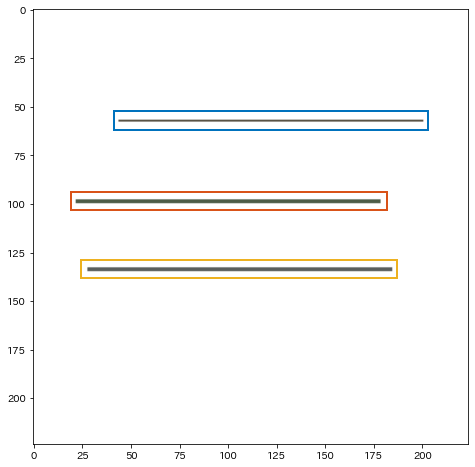

In [ ]:
img, target = test_dataset.__getitem__(0)
plot_pilimg_and_bbox(img.permute(1,2,0).detach().numpy(), target['boxes'])

## 2.5. PyTorch 用データセットの作成

In [ ]:
torch.manual_seed(42)
# 学習・検証用データローダの定義 # define training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=1,
                                           #batch_size=32, 
                                           shuffle=True, 
                                           num_workers=0,
                                           collate_fn=utils.collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=20, 
                                          shuffle=False, 
                                          num_workers=0,
                                          collate_fn=utils.collate_fn)

#print(f'len(train_dataset):{len(train_dataset)}, len(test_dataset):{len(test_dataset)}')
#print(bit.symbols)

for epoch, (imgs, target) in enumerate(train_loader):
    #print(type(target), len(target), target)
    bboxes = target[0]['boxes']
    print(f'epoch:{epoch}, type(imgs[0]):{type(imgs[0])}, imgs[0].size():{imgs[0].size()}, boxes[1]:{bboxes[1]}')
    if epoch >= 1:
        break

epoch:0, type(imgs[0]):<class 'torch.Tensor'>, imgs[0].size():torch.Size([3, 224, 224]), boxes[1]:tensor([ 33.,  45., 195.,  55.])
epoch:1, type(imgs[0]):<class 'torch.Tensor'>, imgs[0].size():torch.Size([3, 224, 224]), boxes[1]:tensor([ 39.,  86., 202.,  95.])


In [ ]:
target

({'boxes': tensor([[ 25.,  61., 188.,  70.],
          [ 39.,  86., 202.,  95.],
          [ 20., 119., 183., 128.],
          [ 41., 150., 204., 160.],
          [ 38., 178., 201., 188.]]),
  'labels': tensor([[1, 1, 1]]),
  'area': tensor([1467., 1467., 1467., 1630., 1630.]),
  'iscrowd': tensor([0, 0, 0, 0, 0]),
  'image_id': tensor([50])},)

# 3. モデルの定義

<!-- モデルを読み込むための関数を定義します。この関数は後で呼び出すことにします -->
<!-- We will define a function for loading the model. We will call it later -->

## 3.1 訓練済モデルのラベルを日本語で定義

In [ ]:
# https://github.com/amikelive/coco-labels を参考に日本語訳したもの 全 91 種類
CLASSES = [
    '背景',                                                       # 0
    '人', '自転車', '車', 'バイク', '飛行機',                        # [01-05]
    'バス', '電車', 'トラック','ボート', '信号機',                    # [06-10]
    '消火栓', '道路標識', '停止サイン', 'パーキングメーター', 'ベンチ',   # [11-15]
    '鳥', '猫', '犬', '馬', '羊',                                   # [16-20]
    '牛', 'ゾウ', '熊',  'シマウマ', 'キリン',                        # [21-25]
    '帽子', 'リュックサック', '傘', '靴', 'メガネ',                    # [26-30]
    'ハンドバッグ',  'ネクタイ', 'スーツケース', 'フリスビー', 'スキー',   # [31-35
    'スノーボード','スポーツボール','凧', '野球バット', '野球グローブ',    # [36-40]
    'スケートボード', 'サーフボード', 'テニスラケット', 'ボトル', '皿',    # [41-45]
     'ワイングラス', 'カップ', 'フォーク', 'ナイフ', 'スプーン',          # [46-50]
    'ボウル', 'バナナ', 'りんご', 'サンドイッチ', 'オレンジ',            # [51-55]
    'ブロッコリー', 'ニンジン', 'ホットドッグ', 'ピザ', 'ドーナツ',      # [56-60]
    'ケーキ', '椅子', 'ソファ', '鉢植え', 'ベッド',                   # [51-65]
    '鏡', 'ダイニングテーブル', '窓', 'デスク', 'トイレ',              # [66-70]
    'ドア', 'テレビ', 'ノートパソコン', 'マウス', 'リモコン',          # [71-75]
    'キーボード',  '携帯電話', '電子レンジ', 'コンロ', 'トースター',    # [76-80]
    '洗面台', '冷蔵庫', 'ミキサー', '本', '時計',                    # [81-85]
    '花瓶', 'ハサミ', 'テディベア', 'ドライヤー', '歯ブラシ']          # [85-90]

# DETR のサンプルプログラムを借用
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

COLORS = COLORS * 100

## 3.2 訓練済モデルの取得関数を定義

In [ ]:
def get_object_detection_model(num_classes):

    # MS-COCO で事前に学習させたモデルを読み込み
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #model = torchvision.models.mobilenet_v2(pretrained=True)
    
    #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    #model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
    #retinanet_model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    #print(retinanet_model.head)

    #ssdlite_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    #print(ssdlite_model.head.classification_head)
    #print(ssdlite_model.head.regression_head)

    # 分類器の入力特徴数の取得
    #print(model.roi_heads) 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(f'変換前 model.roi_heads:{model.roi_heads}')

    # 事前学習済頭部を新しいものに置き換え
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    print(f'変換後 model.roi_heads:{model.roi_heads}')

    return model

# 自作ヘルパー関数を使ってモデルの宣言
num_classes = len(bit.symbols)
model = get_object_detection_model(num_classes)
print(f'num_classes:{num_classes}, bit.symbols:{bit.symbols}')
#print(f'model:{model}')

変換前 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
変換後 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=49, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=196, bias=True)
  )
)
num_classes:49, bit.sy

In [ ]:
#model = torchvision.models.mobilenet_v2(pretrained=True)    
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#[(name, param.size()) for name, param in model.named_parameters()]
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

# 7. 訓練 <!-- # Training-->

訓練用のモデルを準備
<!-- Let's prepare the model for training -->

In [ ]:
[(name, parameter.size()) for name, parameter in model.named_parameters()]

In [ ]:
# 可能なら GPU 上で学習させる
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(bit.symbols)

# 自作ヘルパー関数を使ってモデルを取得
model = get_object_detection_model(num_classes)

# モデルを正しいデバイスへ移動
model.to(device)

# 最適化関数の構成と設定  # construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

# そして 3 エポックごとに学習率を 10 倍ずつ下げる学習率スケジューラ
# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# 10 エポック分訓練 # training for 10 epochs
num_epochs = 10
num_epochs = 1
for epoch in range(num_epochs):
    print(f'エポック:{epoch}')

    model.train()
    # 1 エポック分の訓練  # training for one epoch
    #train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    for images, targets in train_loader:
        print(f'epoch:{epoch}, targets:{targets}') #, targets[1]:{targets[1]}')
        print(f'type(iamges):{type(images)}',
              f'type(targets):{type(targets)}')
        print(f'len(iamges):{len(images)}',
              f'len(targets):{len(targets)}')
        print(f'targets:{targets}')
        loss = model(images, targets)
        #loss = model(images, targets)
    
    # 学習率の更新  # update the learning rate
    lr_scheduler.step()

    #テストデータセットで評価  # evaluate on the test dataset
    evaluate(model, test_loader, device=device)


In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.array([7,8])
for a, b, c:
    print()

In [ ]:
model

In [ ]:
len(bit.symbols)

# 9. モデルの検証 <!-- # Testing our Model -->

In [ ]:
# 検証セットから画像を 1 枚選ぶ
# pick one image from the test set
img, target = dataset_test[np.random.choice(len(dataset))]

# モデルを評価モードにする
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

うおぉぉぉ たくさんの BOX があります。
それらをプロットして，何が予測されたかをチェックしましょう。
<!-- Whoa! Thats a lot of bboxes. Lets plot them and check what did it predict -->

In [ ]:
#print('期待される出力')
plot_img_bbox(torch_to_pil(img), target, title='グランドトルース')

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

このモデルは，すべてのリンゴについて多くのバウンディングボックスを予測していることがわかります。
これに nms を適用し，最終的な出力を見てみましょう。
<!-- You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output -->

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

では，テストセットから画像を取り出し，予測してみましょう。
<!-- Now lets take an image from the test set and try to predict on it -->

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))

# テストセットから画像を 1 枚選ぶ
# pick one image from the test set
#img, target = test_dataset[10]
img, target = test_dataset[np.random.choice(len(test_dataset))]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
#print('期待される出力\n')
# print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, title="グランドトルース")

#print('モデルの出力\n')
# print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, title="モデル予測")

このモデルは，単一物体の画像ではよくできています。
<!-- The model does well on single object images.-->

モデルはスライスも予測していることがわかりますが，これは失敗を意味します☹️ 。
しかし心配しないでください。
これは単なる基本的なモデルであり，我々がそれを改善できるいくつかのアイデアがあります:
<!-- You can see that our model predicts the slices too and that means a failure ☹️ . But fear not, this is just a base line model here are some ideas we can improve it -  -->

1. より良いモデルを使用する。
現在使用しているモデルのバックボーンである `resnet50` を変更し，微調整を行うことが可能です。
2. 画像の大きさ，最適化関数，学習速度のスケジュールなどの学習設定を変更することができる。
3. データ拡張を追加することができる。
ここでは，データ拡張関数の豊富なライブラリを持つ Albumentations ライブラリを使用しました。
自由に探索し，試してみてください。

<!-- 1. Use a better model. 
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out.  -->

# 10. 結果の保存

In [ ]:
torch.save({'model': model.state_dict(),
            'optim': optimizer.state_dict()
           }, '2022_0318fine_tune_fruit.cpt')

`torchvision.transfomrs.functional` あるいは `F` では，3 つ `*.to_*()` 関数が定義されている。
すなわち以下の 3 つである:

* `F.to_grayscale(img, num_output_channels=1))->PIL_Image`: img:PIL_Image をグレイスケールに変換
* `F.to_pil_image(pic, mode=None)->PIL_Image`: pic:[tensor|ndarray] を PIL_Image へ変換
* `F.to_tensor(pic)->torch.Tensor`: pic:[PIL_Image|np.ndarray]  を tensor へ変換
* `F.pil_to_tensor(pic:PIL_Image)->torch.Tensor`: 
逆に torch.Tensor を変換する関数は無いのかしら?

* `F.pil_to_tensor(pic:PIL_Image)->torch.Tensor`
`F.convert_image_dtype(img:torch.Tensor, dtype:torch.dtype=torch.float32)->torch.Tensor`

In [ ]:
import PIL
def plot_pilimg_and_bbox(pil_img:PIL.Image.Image, 
                         bboxes:list):
    """bounding box (物体を囲む四角形の境界領域のことを境界領域箱と呼ぶ): bbox
    PIL 画像を境界領域と共に表示する関数"""
    plt.figure(figsize=(10,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax), c in zip(bboxes, COLORS):
        print(f'xmin:{xmin}, ymin:{ymin}')
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))    

In [ ]:
print(dir(F))
#help(F.pil_to_tensor)
#help(F.torch)
help(F.pil_to_tensor)

In [ ]:
import sys
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20,8)

def torch_imgs_show(imgs):
    """Torch tensor に変換済の画像を表示する"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        if not isinstance(img, PIL.Image.Image):
            #img = img.detach()
            img = F.to_pil_image(img.detach())
        axs[0, i].imshow(np.asarray(img))
        #axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])        

#torch_imgs_show(images)        
#[torch.Tensor(np.array(img)).permute(1,2,0) for img in images]
torch_imgs_show(images[1])

In [ ]:
#help(F.to_pil_image)
_images = [F.to_pil_image(np.array(img)) for img in images]
#type(images[0])
type(_images[0])
#help(F.to_grayscale)
display(images[0])

In [ ]:
import glob
#help(glob.glob)
import sys

In [ ]:
X = np.array([[1,2,3],[4,5,6]])
np.savetxt('xx.txt',X, fmt='%.d')
!cat xx.txt

In [ ]:
#help(np.ndarray.reshape)
help(np.savetxt)
#np.fromfile('data/2022bit_line_bisection/test/test_bboxes.txt',dtype=int).shape

In [ ]:
#print(line_bisection[0][1]['boxes']) # .squeeze(0).size()[0])
#print(line_bisection[0][1]['labels'])

N = 95
_, target = line_bisection.__getitem__(N)
print(f'target["boxes"].squeeze(0).size():{target["boxes"].squeeze(0).size()}')
print(f'len(target["labels"][1]:{len(target["labels"][1])}')
print(f'len(target["boxes"].squeeze(0):{len(target["boxes"].squeeze(0))}')
print(f'line_bisection[N][1]:{line_bisection[N][1]}')

In [ ]:
#line_bisection.__getitem__(95)[1]
[_ for _ in target['labels']]

In [ ]:
N = line_bisection.__len__()
n_imgs = list(np.random.permutation(N))[:2]
for x in n_imgs:
    img, target = line_bisection.__getitem__(x)
    colors = ['cyan' for _ in target['labels']] # [1]]
    print(f'x:{x}, len(colors){len(colors)}', 
          f'colors:{colors}')
    #print(f'targets["boxes"]:{target["boxes"]}')
    
    result = draw_bounding_boxes(img, target['boxes'].squeeze(0), colors=colors, width=15)
    torch_imgs_show(result)

In [ ]:
line_bisection[0]

`class FasterRCNN(torchvision.models.detection.generalized_rcnn.GeneralizedRCNN)`

```python
class FasterRCNN(backbone, 
    num_classes=None, min_size=800, max_size=1333, 
    image_mean=None, image_std=None, 
    rpn_anchor_generator=None, rpn_head=None, 
    rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000, 
    rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000, 
    rpn_nms_thresh=0.7, rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3, 
    rpn_batch_size_per_image=256, rpn_positive_fraction=0.5, rpn_score_thresh=0.0, 
    box_roi_pool=None, box_head=None, box_predictor=None, box_score_thresh=0.05, 
    box_nms_thresh=0.5, box_detections_per_img=100, 
    box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5, 
    box_batch_size_per_image=512, box_positive_fraction=0.25, bbox_reg_weights=None)
```

### Fastr R-CNN の実装 
<!-- Implements Faster R-CNN.-->

モデルへの入力はテンソルのリストであり，それぞれ [C, H, W] の形状で，各画像に対して1つずつ，0-1 の範囲であることが望ましいとされる。
異なる画像は異なるサイズを持つことができる。
<!-- The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each image, and should be in 0-1 range. 
Different images can have different sizes.-->

モデルの動作は，学習モードか評価モードかによって変化する。
<!-- The behavior of the model changes depending if it is in training or evaluation mode. -->

学習時，モデルは入力テンソルと，それを含むターゲット (辞書のリスト) の両方が期待される。
<!-- During training, the model expects both the input tensors, as well as a targets (list of dictionary), containing: -->

- boxes (``FloatTensor[N, 4]``): ``[x1, y1, x2, y2]`` 形式のグランドトルース判定用ボックスで ``0 <= x1 < x2 <= W``, ``0 <= y1 < y2 <= H`` である
- labels (``Int64Tensor[N]``):  各グラウンドトゥルースボックスに対応するクラスラベル。

<!-- - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
- labels (Int64Tensor[N]): the class label for each ground-truth box -->

このモデルは学習時には，RPN と R-CNN の両方の分類と回帰の損失を含む Dict[Tensor] を返す。
<!-- The model returns a Dict[Tensor] during training, containing the classification and regression losses for both the RPN and the R-CNN.-->

推論時には，モデルは入力テンソルだけを必要とし，処理後の予測値を List[Dict[Tensor]] として，各入力画像に対して 1 つずつ返す。
Dict のフィールドは以下の通り:
<!-- During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image.  
The fields of the Dict are as follows:-->

- boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
- labels (``Int64Tensor[N]``): the predicted labels for each image
- scores (``Tensor[N]``): the scores or each prediction

<!-- - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
- labels (Int64Tensor[N]): the predicted labels for each image
- scores (Tensor[N]): the scores or each prediction-->

#### 引数 Args:

* `backbone (nn.Module)`: モデルの特徴を計算するために使用されるネットワーク
バックボーンには `out_channels` 属性が必要で，これは各特徴地図が持つ出力チャネルの数を示す (全ての特徴地図で同じであるべき)。
バックボーンは単一の Tensor または OrderedDict[Tensor] を返す必要がある。
* `num_classes (int)`: モデルの出力クラスの数 (背景も含む)。
box_predictor が指定された場合 `num_classes` は None となる。
* `min_size(int)`:  バックボーンに渡す前に再スケーリングされる画像の最小サイズ．
* `max_size (int)`: バックボーンに渡す前に再スケーリングされる画像の最大サイズ．
* `image_mean (Tuple[float, float, float])`: 入力画像の正規化に利用される平均値．
一般的にはバックボーンを学習させたデータセットの平均値
* `image_std (Tuple[float, float, float])`: 入力の正規化に利用される標準偏差の値．
一般的にはバックボーンを学習させたデータセットの標準偏差を用いる。
* `rpn_anchor_generator (AnchorGenerator)`: 特徴地図の集合のアンカーを生成するモジュール
* `rpn_head (nn.Module)`: RPN から objectness と regression deltas を計算するモジュール
* `rpn_pre_nms_top_n_train (int)`: 学習時に NMS を適用する前に保持すべきプロポーザルの数
* `rpn_pre_nms_top_n_test (int)` : テスト時に NMS を適用する前に保持するプロポーザルの数
* `rpn_post_nms_top_n_train (int)`: 訓練中に NMS を適用した後に保持するプロポーザルの数
* `rpn_post_nms_top_n_train (int)`:  訓練中に NMS を適用した後に保持するプロポジションの数
* `rpn_post_nms_top_n_test (int)`:  テスト時に NMS を適用した後に保持するプロポーザルの数
* `rpn_post_nms_top_n_test (int)`:  テスト時にNMSを適用した後に保持するプロポジションの数
* `rpn_nms_thresh (float)`:  RPN プロポーザルの後処理に使用する NMS の閾値
* `rpn_fg_iou_thresh (float)`: RPN の学習時にアンカーと GT ボックスの間の IoU を正と見なすための最小値
* `rpn_bg_iou_thresh (float)`:  アンカーと GT ボックスの間の IoU の最大値 (RPN の学習時に負とみなすことができる) 。
* `rpn_batch_size_per_image (int)`:  RPN の学習時に損失を計算するためにサンプリングされるアンカーの数．
* `rpn_positive_fraction (float)`:  RPN の訓練中にミニバッチに含まれる正事例アンカーの割合。
* `rpn_score_thresh (float)`: 推論時に `rpn_score_thresh` より大きな分類得点を持つプロポーザルのみを返す。
* `box_roi_pool (MultiScaleRoIAlign)`: バウンディングボックスで示される位置の特徴地図を切り出し，サイズを変更するモジュール
* `box_head (nn.Module)` : 切り出した特徴地図を入力とするモジュール 
* `box_predictor (nn.Module)`:  box_head の出力を受けて，分類ロジットとボックス回帰デルタを返すモジュール 
* `box_score_thresh (nn.Module)`:  分類ロジットとボックス回帰デルタを返すモジュール
* `box_score_thresh (float)`: 推論時 box_score_thresh より大きい分類得点を持つプロポーザルのみを返す。
* `box_nms_thresh (float)`: 予測ヘッドの NMS 閾値。推論時に使用
* `box_detections_per_img (int)`:  全てのクラスについて，画像あたりの最大検出数。
* `box_fg_iou_thresh (float)`:  提案 と GT ボックスの間の最小 IoU  (
分類ヘッドの訓練中に正事例とみなすことができる)．
* `box_bg_iou_thresh (float)`:  プロポーザルと GT ボックスの間の最大 IoU (分類ヘッドの訓練中に負事例とみなすことができる)。
* `box_batch_size_per_image (int)`: 分類ヘッドの訓練中にサンプリングされるプロポーザルの数。
* `box_positive_fraction (float)`: 分類ヘッドの訓練時にミニバッチに含まれる正のプロポーザルの割合。
* `bbox_reg_weights (Tuple[float, float, float, float])`: バウンディングボックスの符号化/復号化のための重み付け

<!-- * `backbone (nn.Module)`: the network used to compute the features for the model. 
It should contain a out_channels attribute, which indicates the number of output channels that each feature map has (and it should be the same for all feature maps).
The backbone should return a single Tensor or and OrderedDict[Tensor].
* `num_classes (int)`: number of output classes of the model (including the background).
If box_predictor is specified, num_classes should be None.
* `min_size (int)`: minimum size of the image to be rescaled before feeding it to the backbone
* `max_size (int)`: maximum size of the image to be rescaled before feeding it to the backbone
* `image_mean (Tuple[float, float, float])`: mean values used for input normalization.
They are generally the mean values of the dataset on which the backbone has been trained on
* `image_std (Tuple[float, float, float])`: std values used for input normalization.
They are generally the std values of the dataset on which the backbone has been trained on
* rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature maps.
* rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
* rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
* rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
* rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
* rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
* rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
* rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be considered as positive during training of the RPN.
* rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be considered as negative during training of the RPN.
* rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN for computing the loss
* rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training of the RPN
* rpn_score_thresh (float): during inference, only return proposals with a classification score greater than rpn_score_thresh 
* box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in the locations indicated by the bounding boxes
* box_head (nn.Module): module that takes the cropped feature maps as input 
* box_predictor (nn.Module): module that takes the output of box_head and returns the classification logits and box regression deltas.
* box_score_thresh (float): during inference, only return proposals with a classification score greater than box_score_thresh
* box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
* box_detections_per_img (int): maximum number of detections per image, for all classes.
* box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be considered as positive during training of the classification head
* box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be considered as negative during training of the classification head
* box_batch_size_per_image (int): number of proposals that are sampled during training of the classification head
* box_positive_fraction (float): proportion of positive proposals in a mini-batch during training of the classification head
* bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the bounding boxes
-->

#### コード例 <!--Example::-->

```python
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 分類用に事前に学習させたモデルをロードし、特徴量のみを返す
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN はバックボーンの出力チャンネル数を知る必要がある
# mobilenet_v2 の場合は 1280 なので，ここに追加する必要がある
backbone.out_channels = 1280

# RPN が空間位置ごとに 5×3 のアンカーを生成するようにする
# 各特徴地図は異なるサイズとアスペクト比を持つ可能性があるため `Tuple[Tuple[int]]` を用意した
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# 関心領域の切り出しに使用する特徴地図と，切り出し後のサイズを定義する
# バックボーンが Tensor を返す場合 `featuremap_names` は `['0’]` であることが期待される。
# より一般的にはバックボーンは `OrderedDict[Tensor]` を返すべきで，`featmap_names` で，どの特徴地図を使うかを選択することができる。
# let's define what are the feature maps that we will use to perform the region of interest cropping, as well as the size of the crop after rescaling. 
# If your backbone returns a Tensor, featmap_names is expected to be ['0']. 
# More generally, the backbone should return an OrderedDict[Tensor], and in featmap_names you can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
```


# 3. 視覚化
<!-- # Visualization -->

In [ ]:
# 画像中のバウンディングボックスを可視化する関数 # Function to visualize bounding boxes in the image

def plot_img_bbox(img, target, title=None):
    # 画像と bbox を描画     # plot the image and bboxes
    # バウンディングボックスは以下のように定義されます: x-min y-min 幅 高さ
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(7,7)
    ax.imshow(img)
    print(target)
    
    for box in target['boxes']:
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 4,
                                 edgecolor = 'red',
                                 facecolor = 'none')

        # 画像上にバウンディングボックスを描画 # Draw the bounding box on top of the image
        ax.add_patch(rect)
        
    if title != None:
        ax.set_title(title)
    plt.show()
    
# bbox を使って画像を描画。インデックスの変更はご自由に
# plotting the image with bboxes. Feel free to change the index
#N = np.random.choice(len(dataset))
#img, target = dataset[N]
#img, target = dataset[25]
#img, target = line_bisection.__getitem__(N)
#print(img.shape, type(img), target.keys(), type(target))
#plot_img_bbox(img[0], target,title=str(N))

bbox が正しく配置されているので、今までうまくいっていたことがわかります。
<!-- You can see that we are doing great till now, as the bbox is correctly placed. -->

一つ注意すべきは，このデータセットでは，完全なリンゴだけを「リンゴ」と予測し，半分にカットされたリンゴは予測しないことを求めている点です。
これは克服すべき課題です。
<!-- One thing to note is that, the dataset wants us to predict only the full apple as "apple" but not the half cut one. 
This will be a challenge to overcome. -->